## 0-Librairies

In [309]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import label_binarize
import seaborn as sns
from tensorflow.keras import optimizers
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, roc_curve, auc
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential, clone_model

## 1 - Data Preparation

In [310]:
X_train = np.load("train_images.npy") 
y_train = np.load("train_labels.npy") 
X_test = np.load("test_images.npy")  
y_test = np.load("test_labels.npy")  

In [311]:
print(f'Shape of data X_train:{X_train.shape}\n')
print(f'Shape of data y_train:{y_train.shape}\n')
print(f'Shape of data X_test:{X_test.shape}\n')
print(f'Shape of data y_test:{y_test.shape}')

Shape of data X_train:(60000, 28, 28, 1)

Shape of data y_train:(60000,)

Shape of data X_test:(10000, 28, 28, 1)

Shape of data y_test:(10000,)


In [312]:
# Normalize images
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

## 2 - Data Viz

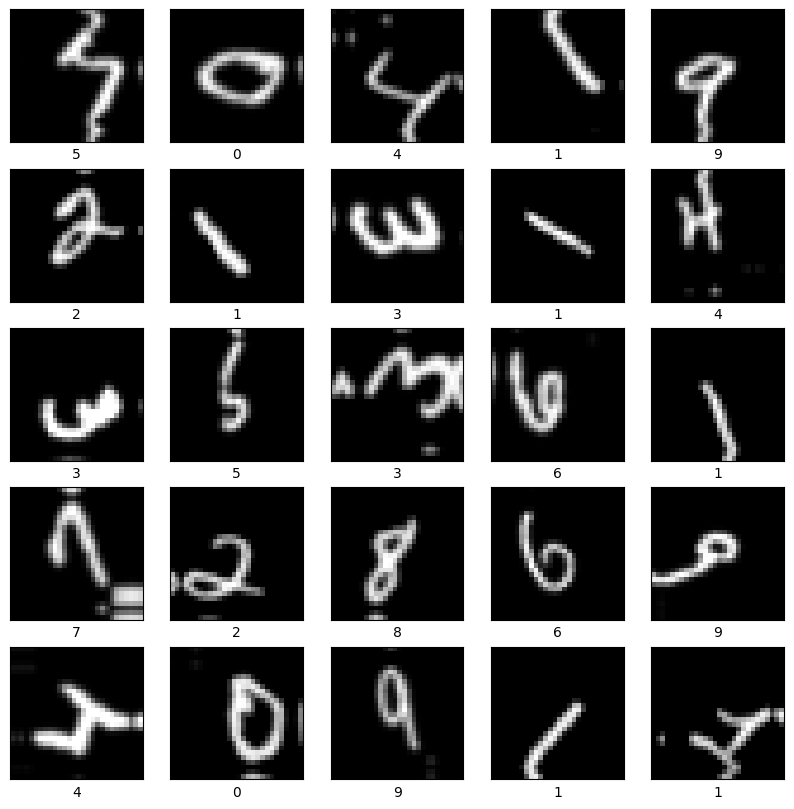

In [313]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.gray)
    plt.xlabel(y_train[i])
plt.show()

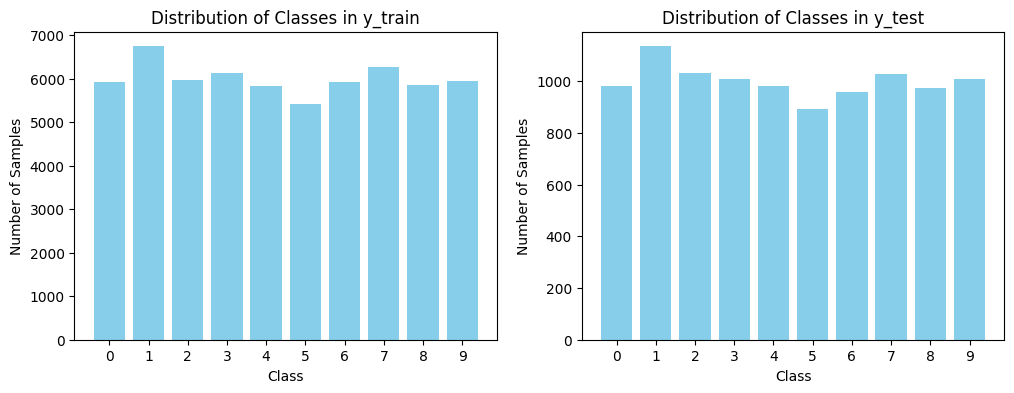

In [314]:
unique_classes_train, counts_train = np.unique(y_train, return_counts=True)
unique_classes_test, counts_test = np.unique(y_test, return_counts=True)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.bar(unique_classes_train, counts_train, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Distribution of Classes in y_train')
plt.xticks(unique_classes_train)  

plt.subplot(1, 2, 2)
plt.bar(unique_classes_test, counts_test, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Distribution of Classes in y_test')
plt.xticks(unique_classes_test)  
plt.show()

## 3 - Dense Modele

### Parameters

In [315]:
# Parameters
epochs_dense = 1 #epochs_dense = 50
batch_size_dense = 128
validation_split_dense = .2
opt_dense = optimizers.Adam(learning_rate=0.01)
early_stop_dense = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

### Change shape of data

In [316]:
# Flatten images for dense model
X_train_flat = X_train.reshape(-1, 784)
X_test_flat = X_test.reshape(-1, 784)

### Modele

In [317]:
# Create and compile the dense model
dense_model = Sequential([
    Dense(256, activation='relu', input_shape=(784,)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

dense_model.compile(optimizer=opt_dense,
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

/home/hbreton/Projets/2-Projets_courts/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [318]:
dense_model.summary()

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_74 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

In [319]:
# Train the dense model
dense_history = dense_model.fit(X_train_flat, y_train,
                                epochs=epochs_dense,
                                batch_size=batch_size_dense,
                                validation_split=validation_split_dense,
                                callbacks=[early_stop_dense])

375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2107 - loss: 2.1435 - val_accuracy: 0.2843 - val_loss: 2.0066


### Results

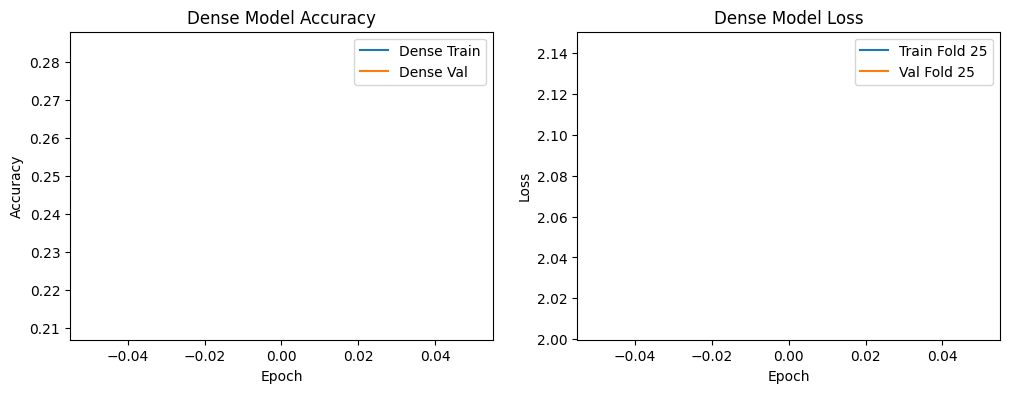

In [320]:
# summarize history for accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(dense_history.history['accuracy'], label='Dense Train')
plt.plot(dense_history.history['val_accuracy'], label='Dense Val')
plt.title('Dense Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(dense_history.history['loss'], label=f'Train Fold {i+1}')
plt.plot(dense_history.history['val_loss'], label=f'Val Fold {i+1}')
plt.title('Dense Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [321]:
# Predict classes using the dense model
y_pred_dense = dense_model.predict(X_test_flat)
y_pred_classes_dense = np.argmax(y_pred_dense, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step


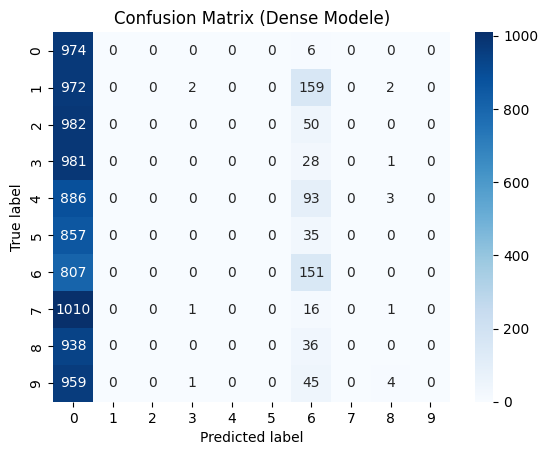

Class 0:
  Sensitivity (SEV): 0.9939
  Specificity (SPE): 0.0696
  F1-score: 0.1883

Class 1:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 1.0000
  F1-score: 0.0000

Class 2:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 1.0000
  F1-score: 0.0000

Class 3:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 0.9996
  F1-score: 0.0000

Class 4:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 1.0000
  F1-score: 0.0000

Class 5:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 1.0000
  F1-score: 0.0000

Class 6:
  Sensitivity (SEV): 0.1576
  Specificity (SPE): 0.9482
  F1-score: 0.1915

Class 7:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 1.0000
  F1-score: 0.0000

Class 8:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 0.9988
  F1-score: 0.0000

Class 9:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 1.0000
  F1-score: 0.0000



In [322]:
# Confusion matrix
matrix = confusion_matrix(y_test, y_pred_classes_dense)  # Compare true labels (y_test) and predicted labels (y_pred_classes_dense)

# Plot confusion matrix
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (Dense Modele)')
plt.show()

# Calculate Sensitivity (SEV) and Specificity (SPE) for each class
for i in range(matrix.shape[0]):
    tp = matrix[i, i]
    fn = np.sum(matrix[i, :]) - tp
    fp = np.sum(matrix[:, i]) - tp
    tn = np.sum(matrix) - tp - fn - fp
    f1 = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0  # F1-score
    sev = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity (Recall)
    spe = tn / (tn + fp) if (tn + fp) > 0 else 0  # Specificity
    print(f'Class {i}:')
    print(f'  Sensitivity (SEV): {sev:.4f}')
    print(f'  Specificity (SPE): {spe:.4f}')
    print(f'  F1-score: {f1:.4f}\n')

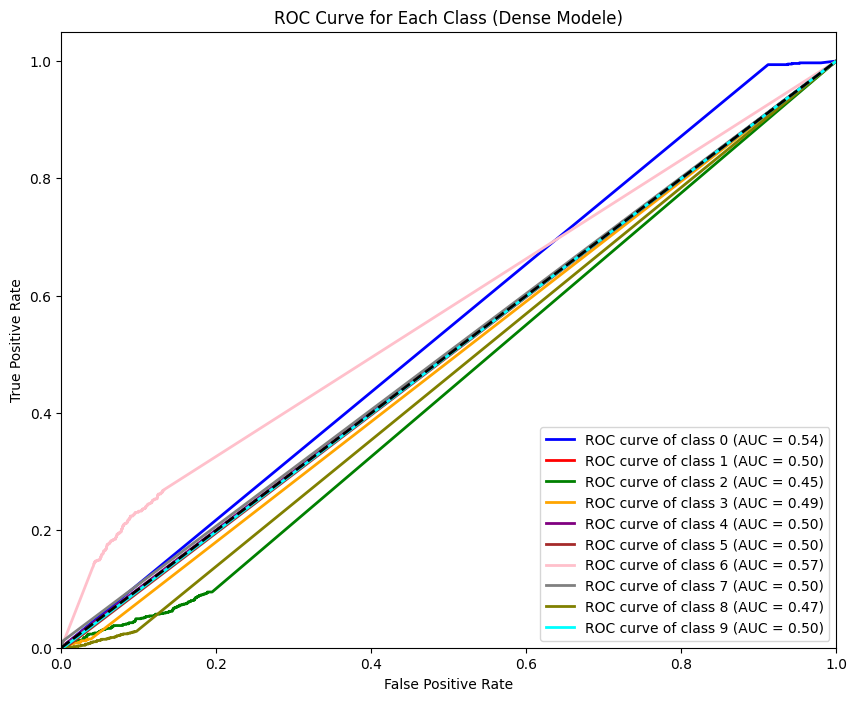

In [323]:
# Binarize the output for ROC curve (one-vs-rest)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_dense[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class (Dense Modele)')
plt.legend(loc="lower right")
plt.show()

## 4 - CNN Modele

### Parameters

In [324]:
# Parameters
epochs_cnn = 5
batch_size_cnn = 50
validation_split_cnn = .2
opt_cnn = optimizers.Adam(learning_rate=0.001)
early_stop_cnn = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
k_folds = 5 

### Change shape of data

In [325]:
# Reshape images for CNN model
X_train_cnn = X_train.reshape(-1, 28, 28, 1)
X_test_cnn = X_test.reshape(-1, 28, 28, 1)

### Modele

In [326]:
# Create and compile the CNN model
# cnn_model = Sequential([
#     Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)),
#     BatchNormalization(),
#     MaxPooling2D((2, 2)),
#     Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'),
#     BatchNormalization(),
#     MaxPooling2D((2, 2)),
#     Flatten(),
#     Dense(50, kernel_initializer='he_uniform', activation='relu'),
#     Dropout(0.3),
#     Dense(10, activation='softmax')
# ])

# cnn_model.compile(optimizer=opt_cnn,
#                   loss='sparse_categorical_crossentropy',
#                   metrics=['accuracy'])

In [327]:
def create_cnn_model():
    cnn_model = Sequential([
        Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(50, kernel_initializer='he_uniform', activation='relu'),
        Dropout(0.3),
        Dense(10, activation='softmax')
        ])

    cnn_model.compile(optimizer=opt_cnn,
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy']
        )
    return cnn_model

In [328]:
# cnn_model.summary()

In [329]:
# Train the CNN model
# cnn_history = cnn_model.fit(X_train_cnn, y_train,
#                             epochs=epochs_cnn,
#                             batch_size=batch_size_cnn,
#                             validation_split=validation_split_cnn,
#                             callbacks=[early_stop_cnn])

In [330]:
# Initialiser StratifiedKFold
skf = StratifiedKFold(n_splits=k_folds, shuffle=True)

# Initialiser une liste pour stocker les résultats
fold_results = []
best_cnn_model = None
best_accuracy = 0.0
best_cnn_history = None

# Cross-validation
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_cnn, y_train)):
    print(f"\nFold {fold + 1}/{k_folds}")

    # Diviser les données en train/validation pour ce fold
    X_train_fold, X_val_fold = X_train_cnn[train_idx], X_train_cnn[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # Créer une nouvelle instance du modèle
    cnn_model = create_cnn_model()

    # Entraîner le modèle sur ce fold
    history = cnn_model.fit(
        X_train_fold, y_train_fold,
        epochs=epochs_cnn,
        batch_size=batch_size_cnn,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stop_cnn],
        verbose=1
    )

    # Évaluer le modèle sur le fold de validation
    val_loss, val_accuracy = cnn_model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f"Validation accuracy for fold {fold + 1}: {val_accuracy:.4f}")

    # Stocker les résultats
    fold_results.append(val_accuracy)

    # Garder le meilleur modèle
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_cnn_model = cnn_model
        best_cnn_history = history

# Afficher les résultats
print("\nCross-validation results:")
for i, accuracy in enumerate(fold_results):
    print(f"Fold {i + 1}: Validation accuracy = {accuracy:.4f}")

print(f"\nBest validation accuracy: {best_accuracy:.4f}")

# Retourner le meilleur modèle
print("\nBest model summary:")
best_cnn_model.summary()


Fold 1/5


/home/hbreton/Projets/2-Projets_courts/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
960/960 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - accuracy: 0.5125 - loss: 1.4037 - val_accuracy: 0.7591 - val_loss: 0.7749
Epoch 2/5
960/960 ━━━━━━━━━━━━━━━━━━━━ 39s 41ms/step - accuracy: 0.7508 - loss: 0.7638 - val_accuracy: 0.8366 - val_loss: 0.5331
Epoch 3/5
772/960 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.8030 - loss: 0.6103

KeyboardInterrupt: 

### Results

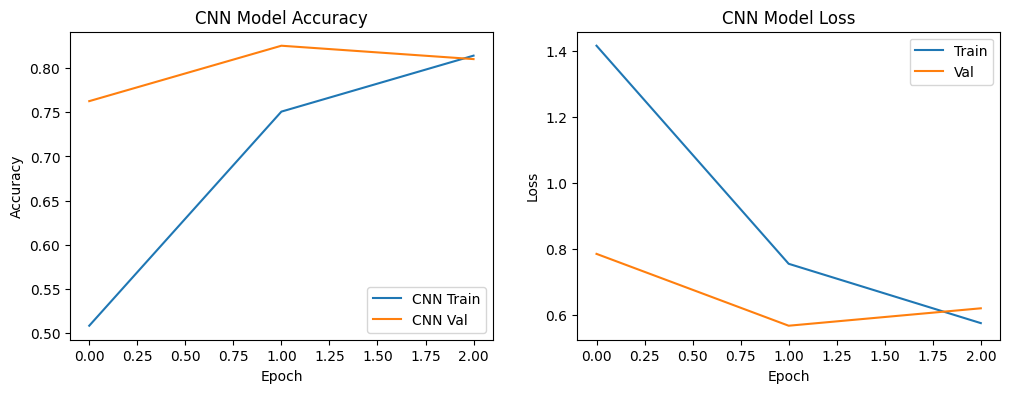

In [ ]:
# Accuracy
plt.subplot(1, 2, 1)
plt.plot(best_cnn_history.history['accuracy'], label='CNN Train')
plt.plot(best_cnn_history.history['val_accuracy'], label='CNN Val')
plt.title('Best CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(best_cnn_history.history['loss'], label='Train')
plt.plot(best_cnn_history.history['val_loss'], label='Val')
plt.title('Best CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Predict classes using the cnn model
y_pred_cnn = best_cnn_model.predict(X_test_cnn)
y_pred_classes_cnn = np.argmax(y_pred_cnn, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


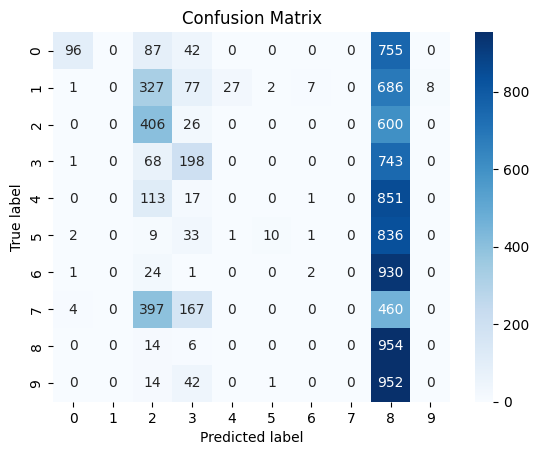

Class 0:
  Sensitivity (SEV): 0.0980
  Specificity (SPE): 0.9990

  F1-score: 0.1770

Class 1:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 1.0000

  F1-score: 0.0000

Class 2:
  Sensitivity (SEV): 0.3934
  Specificity (SPE): 0.8826

  F1-score: 0.3260

Class 3:
  Sensitivity (SEV): 0.1960
  Specificity (SPE): 0.9543

  F1-score: 0.2446

Class 4:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 0.9969

  F1-score: 0.0000

Class 5:
  Sensitivity (SEV): 0.0112
  Specificity (SPE): 0.9997

  F1-score: 0.0221

Class 6:
  Sensitivity (SEV): 0.0021
  Specificity (SPE): 0.9990

  F1-score: 0.0041

Class 7:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 1.0000

  F1-score: 0.0000

Class 8:
  Sensitivity (SEV): 0.9795
  Specificity (SPE): 0.2452

  F1-score: 0.2183

Class 9:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 0.9991

  F1-score: 0.0000



In [ ]:
# Confusion matrix
matrix = confusion_matrix(y_test, y_pred_classes_cnn)  # Compare true labels (y_test) and predicted labels (y_pred_classes_dense)

# Plot confusion matrix
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

# Calculate Sensitivity (SEV) and Specificity (SPE) for each class
for i in range(matrix.shape[0]):
    tp = matrix[i, i]
    fn = np.sum(matrix[i, :]) - tp
    fp = np.sum(matrix[:, i]) - tp
    tn = np.sum(matrix) - tp - fn - fp
    f1 = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0  # F1-score
    sev = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity (Recall)
    spe = tn / (tn + fp) if (tn + fp) > 0 else 0  # Specificity
    print(f'Class {i}:')
    print(f'  Sensitivity (SEV): {sev:.4f}')
    print(f'  Specificity (SPE): {spe:.4f}\n')
    print(f'  F1-score: {f1:.4f}\n')

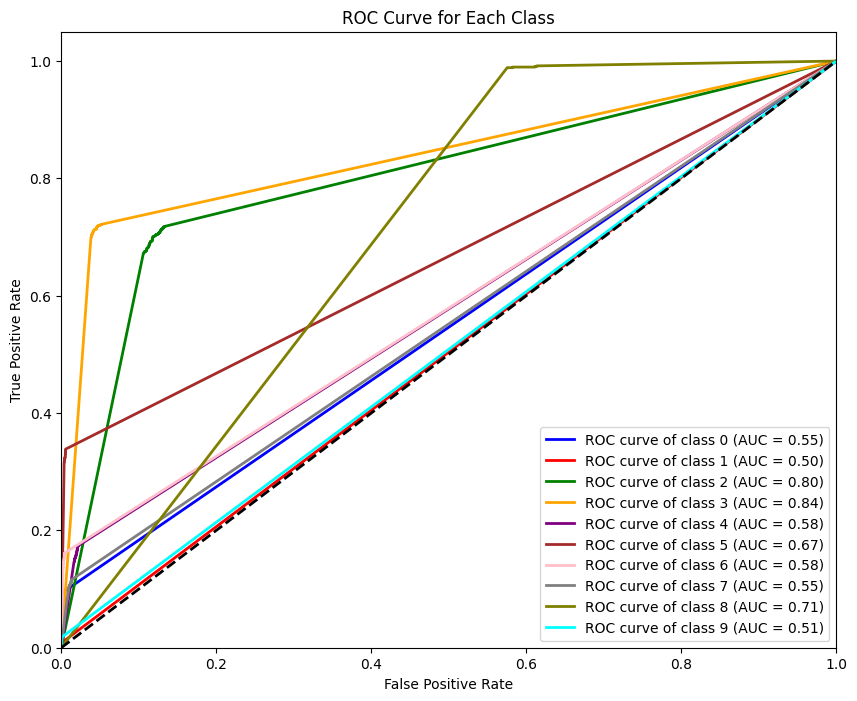

In [ ]:
# Binarize the output for ROC curve (one-vs-rest)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_cnn[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()